# Computer Vision 1: Image classification

**Note:** This notebook was adapted from this [tutorial on image classification](https://www.tensorflow.org/tutorials/images/classification).

## 1 What is computer vision?

Computer vision is a field of artificial intelligence and computer science that focuses on enabling machines to interpret, analyze, and understand **visual information** from the world around us. It involves the development of algorithms and techniques that enable computers to automatically extract information from **images, videos, and other visual data**.

There are several possible applications of computer vision. These week, we will be looking at classifiying images, detecting objects within images, and segmenting pixels within an image.
![Computer vision applications](cold.jpeg)

* **Image classification:** Image classification is a computer vision task that involves categorizing an input image into one of several predefined classes or categories. The goal is to accurately identify the dominant object or scene in the image.


* **Object detection:** Object detection is a computer vision task that involves identifying and localizing objects within an image or video stream. The goal is to accurately detect the presence of objects and draw bounding boxes around them.


* **Pixel-level or segmentation or semantic segmentation:** Semantic segmentation is a computer vision task that involves dividing an input image into regions that correspond to different objects or parts of objects. The goal is to assign each pixel in the image to a specific class or category, based on its visual characteristics and context. This technique is often used in applications such as autonomous driving, where it is necessary to accurately identify the road, other vehicles, and pedestrians. It is also widely used in medical imaging, to identify different kinds of tissues and organs within medical scans.

## 2 Introduction to image classification with TensorFlow and Keras

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`, for efficiently loading a dataset off disk.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

### 2.1 Setup
We begin by importing TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### 2.2 Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 11s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

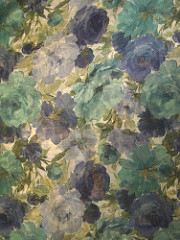

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

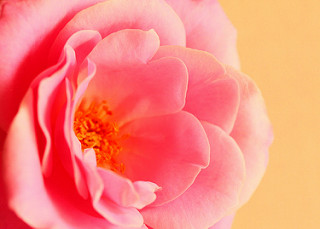

In [5]:
PIL.Image.open(str(roses[1]))

And some tulips:

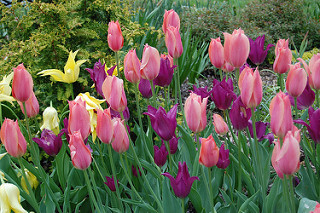

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

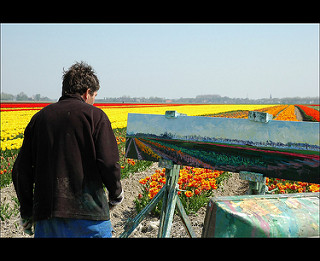

In [7]:
PIL.Image.open(str(tulips[1]))

### 2.3 Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 2.4 Visualize the data

Here are the first nine images from the training dataset:

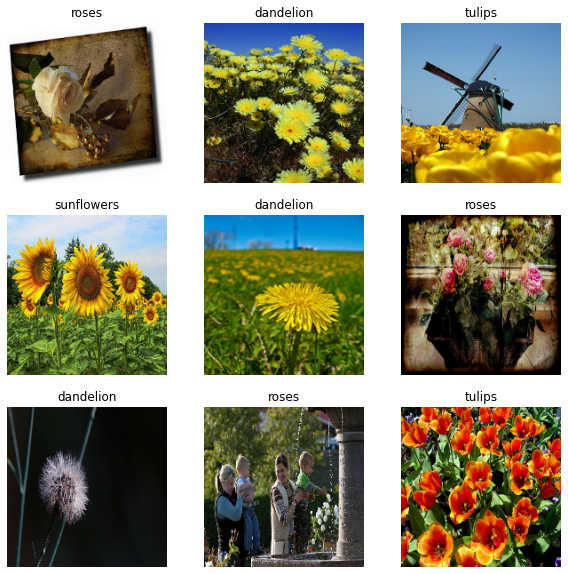

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


### 2.5 Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 2.6 Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [15]:
normalization_layer = layers.Rescaling(1./255)

You can now include this layer inside your model definition, which can simplify deployment.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### 2.7 Create the Keras model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 2.8 Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 2.9 Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes = True, dpi = 96)

### 2.10 Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 20s 53ms/step - loss: 1.4320 - accuracy: 0.3948 - val_loss: 1.1218 - val_accuracy: 0.5409
Epoch 2/10
92/92 [==============================] - 2s 23ms/step - loss: 1.0440 - accuracy: 0.5702 - val_loss: 0.9987 - val_accuracy: 0.5763
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.8537 - accuracy: 0.6686 - val_loss: 0.8843 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.6324 - accuracy: 0.7640 - val_loss: 0.9244 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.4307 - accuracy: 0.8420 - val_loss: 0.9440 - val_accuracy: 0.6757
Epoch 6/10
92/92 [==============================] - 2s 24ms/step - loss: 0.2389 - accuracy: 0.9196 - val_loss: 1.1575 - val_accuracy: 0.6649
Epoch 7/10
92/92 [==============================] - 2s 21ms/step - loss: 0.1267 - accuracy: 0.9619 - val_loss: 1.2947 - val_accuracy: 0.6349
Epoch 8/10
9

### 2.11 Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

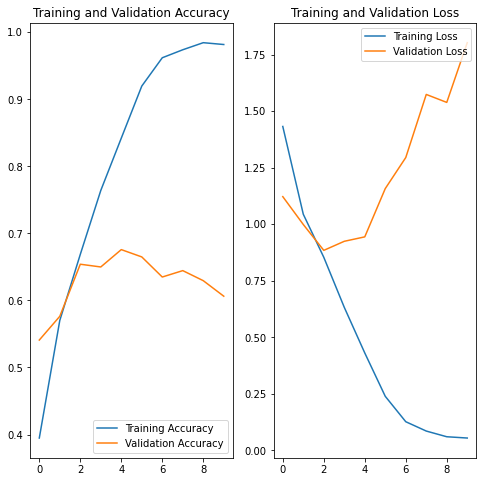

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Next week we will see how to inspect what went wrong and try to increase the overall performance of the model. For now, can you guess what is going wrong. by looking at the loss curves?

## 3 Exercises

For the exercise, you will be working with a dataset that contains images of cats and dogs. Your task is to classify these images into two categories - cats and dogs. What is the highest accuracy that you can achieve?

We will obtain the data using the [TensorFlow Datasets](https://www.tensorflow.org/datasets) library. TensorFlow datasets are generators that provide batches of data + labels when they are called.

In [2]:
import tensorflow_datasets as tfds

classNames = ['cat', 'dog']
split = ['train[:80%]', 'train[80%:90%]', 'train[-10%:]']

((trainDataset, valDataset, testDataset), ds_info) = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True, with_info=True)

You can visualize the images in a dataset using TensorFlow dataset visualization methods.

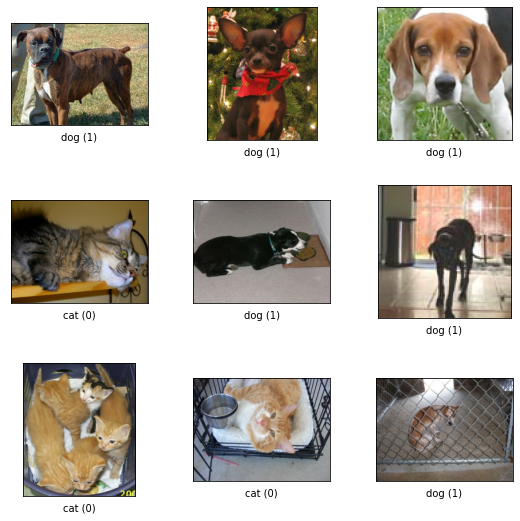

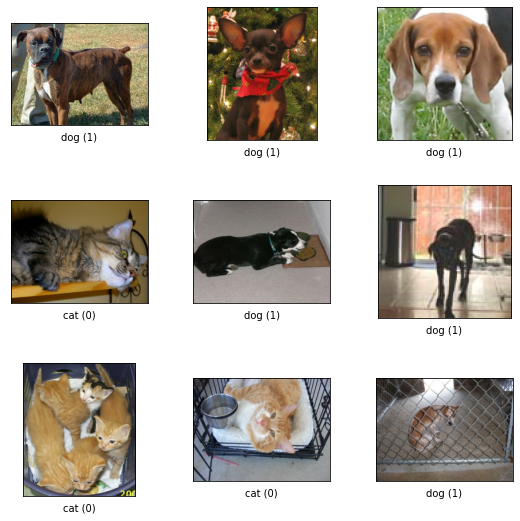

In [3]:
tfds.visualization.show_examples(
    trainDataset, ds_info
)

**Notes:**
* The images in the dataset have different sizes. You will have to resize them to fit as inputs to your convolutional neural network. The code to do so when working with TensorFlow datasets is provided below.
* The images will have to be preprocessed (for example, by normalizing / standardizing).
* There are 2 possible output classes here. Think about which loss function is most appropriate to use in this case.

In [4]:
# Image parameters
img_height = 200
img_width = 200

def preprocess_images(image, label):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (img_height, img_width))
    return image, label

trainDataset = trainDataset.map(preprocess_images)
valDataset = valDataset.map(preprocess_images)
testDataset = testDataset.map(preprocess_images)

# shuffle and create batches before training
train_batches = trainDataset.shuffle(1024).batch(32)
validation_batches = valDataset.shuffle(1024).batch(32)

When you have built the model, call model.fit on train_batches and the argument validation_data = validation_batches.

In [5]:
# Your code here

# Building the model

model = Sequential([
    layers.Conv2D(16, 3, input_shape = (img_height, img_width, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1) # One output neuron to predict 1 or 0
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history = model.fit(train_batches, validation_data = validation_batches, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
582/582 [==============================] - 58s 78ms/step - loss: 0.6421 - accuracy: 0.5974 - val_loss: 0.5438 - val_accuracy: 0.6711
Epoch 2/10
582/582 [==============================] - 43s 71ms/step - loss: 0.4947 - accuracy: 0.7426 - val_loss: 0.4881 - val_accuracy: 0.7807
Epoch 3/10
582/582 [==============================] - 50s 83ms/step - loss: 0.3977 - accuracy: 0.8110 - val_loss: 0.4723 - val_accuracy: 0.7919
Epoch 4/10
582/582 [==============================] - 45s 76ms/step - loss: 0.2821 - accuracy: 0.8732 - val_loss: 0.5167 - val_accuracy: 0.7885
Epoch 5/10
582/582 [==============================] - 45s 74ms/step - loss: 0.1521 - accuracy: 0.9367 - val_loss: 0.7390 - val_accuracy: 0.8018
Epoch 6/10
582/582 [==============================] - 45s 75ms/step - loss: 0.0705 - accuracy: 0.9737 - val_loss: 0.9777 - val_accuracy: 0.7837
Epoch 7/10
582/582 [==============================] - 45s 74ms/step - loss: 0.0430 - accuracy: 0.9850 - val_loss: 1.0711 - val_accuracy: